In [1]:
import torch, torch.utils.data
import torch.nn as nn
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms

import numpy as np
import gc 
import math
from scipy import stats
import nibabel as ni 
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib import cm
import os,sys, glob
import trainer_dataugmentation_fix_t as ptt
from PIL import Image
%matplotlib inline
cuda_aval = torch.cuda.is_available()
print('GPU available:',cuda_aval)
import warnings
warnings.filterwarnings("ignore")
torch.set_printoptions(threshold=5000)

GPU available: True


In [2]:
def get_labels(y_out,ind_end,ind_start,nlabels):
    ind_end_pred = np.add.accumulate(np.array(ind_end)-np.array(ind_start))
    ind_start_pred = np.zeros_like(ind_end_pred)
    ind_start_pred[1:] = ind_end_pred[:-1]

    y_prob_pred = [np.sum(y_out[i:j]==0)/(j-i).astype(float) for i,j in zip(ind_start_pred,ind_end_pred)]
    for label_true in nlabels[1:]:
        y_prob_temp = [np.sum(y_out[i:j]==label_true)/(j-i).astype(float) 
                       for i,j in zip(ind_start_pred,ind_end_pred)]
        y_prob_pred = np.vstack((y_prob_pred,y_prob_temp))
    return y_prob_pred, np.argmax(y_prob_pred,axis=0)

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor 

In [3]:
dir_bas =   '/home/mariana/Documents/Data_2D/NCMCI/'+'images_total.npy'
dir_bas2 =  '/home/mariana/Documents/Data_2D/NCMCI/'+'labels.npy'
dir_bas3 =  '/home/mariana/Documents/Data_2D/NCMCI/'+'labels_suj.npy'
dir_bas4 =  '/home/mariana/Documents/Data_2D/NCMCI/'+'ind_suj.npy'
dir_bas5 =  '/home/mariana/Documents/Data_2D/NCMCI/'+'n_labels.npy'
dir_bas6 =  '/home/mariana/Documents/Data_2D/NCMCI/'+'num_suj.npy'

images_total = np.load(dir_bas)
labels       = np.load(dir_bas2)
labels_suj   = np.load(dir_bas3)
ind_suj      = np.load(dir_bas4)
n_labels     = np.load(dir_bas5)
num_suj      = np.load(dir_bas6)

print(images_total.shape)
print(labels.shape)
print(len(labels_suj))
print(len(ind_suj))
print(n_labels.shape)
print(num_suj)

(14000, 3, 100, 100)
(14000, 1)
350
351
(2,)
350


In [3]:

class MyResNetConv(torch.nn.Module):
    def __init__(self, fixed_feature=True):
        super().__init__()
        self.my_resnet34_model = models.resnet34(pretrained=True)
        del self.my_resnet34_model.layer3
        del self.my_resnet34_model.layer4
        del self.my_resnet34_model.fc
        for param in self.parameters():
            param.requires_grad = False
    def forward(self, x):        
        x = self.my_resnet34_model.conv1(x)
        x = self.my_resnet34_model.bn1(x)
        x = self.my_resnet34_model.relu(x)
        x = self.my_resnet34_model.maxpool(x)
        x = self.my_resnet34_model.layer1(x)
        x = self.my_resnet34_model.layer2(x) 
        x = self.my_resnet34_model.avgpool(x)
        x = x.view(x.size(0), -1)
        return x


class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens3 = torch.nn.Linear(in_features=130, out_features=64)
        self.drop3 = torch.nn.Dropout2d(p=0.25)
        self.dens4 = torch.nn.Linear(in_features=64, out_features=2) 

    def forward(self, x):
        x = self.dens3(x)
        x = torch.nn.functional.relu(x)
        x = self.drop3(x)
        x = self.dens4(x)
        return x


class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
        
    def forward(self, x):
        fea = self.mrnc(x[0])
        x_aux = torch.squeeze(x[1].data,1)
        print('here',x_aux.cpu())
        x = torch.cat((fea, x_aux),1) 
        x = self.mrnd(x)
        return x

model = MyResNet()
if cuda_aval:
    model = model.cuda()
print(model)

MyResNet(
  (mrnc): MyResNetConv(
    (my_resnet34_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [5]:
inp_set = torch.Tensor(images_total)
if cuda_aval:
    inp_set = inp_set.cuda()
feat_set = inp_set

print(feat_set.size())

torch.Size([14000, 3, 100, 100])


In [4]:
n_epochs = 1000 
criterion = torch.nn.CrossEntropyLoss()
data_transf = transforms.Compose([ptt.RandomCrop(64)]) 

In [7]:
skf = StratifiedShuffleSplit(n_splits=1, test_size=70, train_size=280, random_state=996622)
batch_size = 32
X = np.arange(num_suj)
acc_kfold = []
fold = 0
trainer = {}
final_loss_train = np.array([]).reshape(0,n_epochs)
final_loss_valid = np.array([]).reshape(0,n_epochs)
final_acc_train = np.array([]).reshape(0,n_epochs)
final_acc_valid = np.array([]).reshape(0,n_epochs)

for train_s, valid_s in skf.split(X, labels_suj):
    model = MyResNet()
    if cuda_aval: 
        model = model.cuda()
        
    optimizer = optim.Adam(model.mrnd.parameters(), lr=0.0005)#, momentum=0.8)
    fp_model = './Resn_NCMCI_Cor{}'.format(fold)
    cb_chkpt = ptt.ModelCheckpoint(fp_model, reset=True, verbose=1)

    trainer["string{0}".format(fold)] = ptt.DeepNetTrainer(model = model, criterion = criterion, optimizer = optimizer,
                                        data_transf = data_transf,
                                        callbacks = [ptt.AccuracyMetric(), cb_chkpt, ptt.PrintCallback()])

    ind_start_train = np.take(ind_suj[:-1],train_s)
    ind_end_train = np.take(ind_suj[1:],train_s)

    x_train = torch.cat([feat_set[i:j] for i,j in zip(ind_start_train,ind_end_train)])
    labels_train = np.concatenate([labels[i:j] for i,j in zip(ind_start_train,ind_end_train)])
    y_train = torch.LongTensor(labels_train)

    ind_start_valid = np.take(ind_suj[:-1],valid_s)
    ind_end_valid = np.take(ind_suj[1:],valid_s)

    x_valid = torch.cat([feat_set[i:j] for i,j in zip(ind_start_valid,ind_end_valid)])
    labels_valid = np.concatenate([labels[i:j] for i,j in zip(ind_start_valid,ind_end_valid)])
    y_valid_true = labels_suj[valid_s].astype("uint8")
    y_valid = torch.LongTensor(labels_valid)

    y_train = torch.LongTensor(labels)

    train_loader = DataLoader(ptt.create_dataloaders(feat_set, y_train, transform=data_transf, n_epochs=n_epochs), 
                          batch_size=batch_size, shuffle=True)

    valid_loader = DataLoader(ptt.create_dataloaders(x_valid, y_valid, transform=data_transf, n_epochs=n_epochs),
                           batch_size=batch_size, shuffle=True) 

    trainer["string{0}".format(fold)].fit_loader(n_epochs, train_loader, valid_data=valid_loader)


    final_loss_train = np.vstack((final_loss_train,trainer["string{0}".format(fold)].metrics['train']['losses']))
    final_loss_valid = np.vstack((final_loss_valid,trainer["string{0}".format(fold)].metrics['valid']['losses']))
    final_acc_train = np.vstack((final_acc_train,trainer["string{0}".format(fold)].metrics['train']['acc']))
    final_acc_valid = np.vstack((final_acc_valid,trainer["string{0}".format(fold)].metrics['valid']['acc']))

    del x_train, y_train, x_valid, y_valid
    gc.collect()
    fold += 1 

Start training for 1000 epochs
  1:   3.1s   T: 0.02167 0.51121   V: 0.02178 0.49214 best
  2:   2.8s   T: 0.02164 0.52207   V: 0.02187 0.50000 
  3:   2.7s   T: 0.02158 0.53314   V: 0.02173 0.49821 best
  4:   2.7s   T: 0.02149 0.54071   V: 0.02163 0.54536 best
  5:   2.7s   T: 0.02146 0.54343   V: 0.02160 0.53607 best
  6:   2.8s   T: 0.02137 0.55743   V: 0.02157 0.53071 best
  7:   2.9s   T: 0.02128 0.56050   V: 0.02155 0.54143 best
  8:   3.0s   T: 0.02125 0.56350   V: 0.02145 0.55250 best
  9:   2.8s   T: 0.02125 0.56157   V: 0.02152 0.54464 
 10:   2.8s   T: 0.02118 0.56600   V: 0.02145 0.55750 best
 11:   2.8s   T: 0.02116 0.56771   V: 0.02139 0.55536 best
 12:   2.8s   T: 0.02114 0.57321   V: 0.02143 0.55036 
 13:   3.0s   T: 0.02110 0.57100   V: 0.02147 0.55143 
 14:   2.8s   T: 0.02108 0.57493   V: 0.02132 0.56464 best
 15:   2.7s   T: 0.02103 0.57814   V: 0.02148 0.54143 
 16:   2.8s   T: 0.02106 0.57179   V: 0.02161 0.54036 
 17:   2.8s   T: 0.02104 0.57921   V: 0.02151 0.5

148:   5.3s   T: 0.02012 0.61586   V: 0.02054 0.58821 
149:   5.3s   T: 0.02009 0.61557   V: 0.02061 0.60036 
150:   5.3s   T: 0.02014 0.61950   V: 0.02040 0.60393 
151:   5.3s   T: 0.02016 0.61771   V: 0.02079 0.59321 
152:   5.3s   T: 0.02008 0.61486   V: 0.02055 0.59286 
153:   5.3s   T: 0.02015 0.61700   V: 0.02048 0.58393 
154:   5.3s   T: 0.02009 0.62100   V: 0.02092 0.58786 
155:   5.3s   T: 0.02009 0.61729   V: 0.02042 0.60286 
156:   5.3s   T: 0.02008 0.62193   V: 0.02059 0.60179 
157:   5.3s   T: 0.02006 0.61850   V: 0.02037 0.59929 
158:   5.3s   T: 0.02006 0.61836   V: 0.02051 0.59643 
159:   5.4s   T: 0.02003 0.62514   V: 0.02046 0.60607 
160:   5.4s   T: 0.02003 0.62307   V: 0.02049 0.58857 
161:   5.5s   T: 0.02003 0.62321   V: 0.02049 0.60036 
162:   5.4s   T: 0.02003 0.62050   V: 0.02090 0.59821 
163:   5.3s   T: 0.02000 0.62579   V: 0.02062 0.60500 
164:   5.3s   T: 0.02004 0.61936   V: 0.02052 0.59643 
165:   5.3s   T: 0.02000 0.61950   V: 0.02040 0.60964 
166:   5.3

297:   5.3s   T: 0.01951 0.63914   V: 0.01999 0.62321 
298:   5.3s   T: 0.01962 0.63736   V: 0.02027 0.61643 
299:   5.3s   T: 0.01957 0.63793   V: 0.01988 0.62571 
300:   5.3s   T: 0.01963 0.62886   V: 0.01986 0.63821 
301:   5.3s   T: 0.01964 0.63200   V: 0.01979 0.60857 
302:   5.3s   T: 0.01967 0.63507   V: 0.01973 0.63286 
303:   5.3s   T: 0.01975 0.63893   V: 0.02007 0.62357 
304:   5.3s   T: 0.01962 0.63536   V: 0.02025 0.61500 
305:   5.3s   T: 0.01967 0.63821   V: 0.01990 0.61929 
306:   5.3s   T: 0.01953 0.63657   V: 0.01999 0.62464 
307:   5.3s   T: 0.01970 0.63021   V: 0.01969 0.62643 
308:   5.3s   T: 0.01959 0.63336   V: 0.02025 0.60750 
309:   5.3s   T: 0.01958 0.63707   V: 0.01965 0.63214 
310:   5.3s   T: 0.01971 0.63629   V: 0.01980 0.62893 
311:   5.3s   T: 0.01968 0.63564   V: 0.01975 0.62071 
312:   5.3s   T: 0.01977 0.63093   V: 0.01980 0.62786 
313:   5.3s   T: 0.01958 0.63136   V: 0.02012 0.62143 
314:   5.3s   T: 0.01960 0.63421   V: 0.01994 0.62179 
315:   5.3

446:   5.3s   T: 0.01935 0.64571   V: 0.01936 0.64036 
447:   5.3s   T: 0.01951 0.63821   V: 0.01937 0.65214 
448:   5.3s   T: 0.01949 0.63650   V: 0.01935 0.63821 
449:   5.3s   T: 0.01932 0.64986   V: 0.01979 0.62321 
450:   5.3s   T: 0.01954 0.63921   V: 0.01959 0.64214 
451:   5.3s   T: 0.01939 0.64286   V: 0.01967 0.63750 
452:   5.3s   T: 0.01959 0.64121   V: 0.01976 0.62536 
453:   5.3s   T: 0.01949 0.64000   V: 0.01958 0.64393 
454:   5.3s   T: 0.01928 0.64657   V: 0.01997 0.62714 
455:   5.3s   T: 0.01945 0.64436   V: 0.01940 0.64286 
456:   5.3s   T: 0.01947 0.63964   V: 0.01966 0.62464 
457:   5.3s   T: 0.01944 0.64271   V: 0.01951 0.64214 
458:   5.3s   T: 0.01940 0.64536   V: 0.01964 0.64179 
459:   5.3s   T: 0.01949 0.64221   V: 0.01929 0.64857 
460:   5.3s   T: 0.01932 0.64371   V: 0.01935 0.65214 
461:   5.3s   T: 0.01944 0.63829   V: 0.01945 0.64714 
462:   5.3s   T: 0.01947 0.64700   V: 0.01966 0.63357 
463:   5.3s   T: 0.01931 0.64636   V: 0.01947 0.64393 
464:   5.3

595:   5.3s   T: 0.01918 0.65350   V: 0.01960 0.63929 
596:   5.3s   T: 0.01931 0.64714   V: 0.01934 0.65107 
597:   5.3s   T: 0.01936 0.64307   V: 0.01918 0.65000 
598:   5.3s   T: 0.01933 0.64243   V: 0.01930 0.64393 
599:   5.3s   T: 0.01936 0.63979   V: 0.01952 0.63571 
600:   5.3s   T: 0.01934 0.64057   V: 0.01954 0.64071 
601:   5.3s   T: 0.01933 0.64486   V: 0.01952 0.64071 
602:   5.3s   T: 0.01922 0.64671   V: 0.01943 0.64750 
603:   5.3s   T: 0.01938 0.64386   V: 0.01956 0.62750 
604:   5.3s   T: 0.01932 0.64329   V: 0.01932 0.64857 
605:   5.3s   T: 0.01937 0.64536   V: 0.01948 0.63929 
606:   5.3s   T: 0.01933 0.64657   V: 0.01953 0.63500 
607:   5.3s   T: 0.01926 0.64307   V: 0.01878 0.66214 best
608:   5.3s   T: 0.01926 0.64400   V: 0.01912 0.64571 
609:   5.3s   T: 0.01930 0.64650   V: 0.01913 0.64857 
610:   5.3s   T: 0.01918 0.64864   V: 0.01987 0.64179 
611:   5.3s   T: 0.01930 0.64493   V: 0.01932 0.64250 
612:   5.3s   T: 0.01931 0.64550   V: 0.01966 0.63643 
613:  

744:   5.4s   T: 0.01927 0.64479   V: 0.01924 0.65107 
745:   5.4s   T: 0.01918 0.64764   V: 0.01961 0.63321 
746:   5.3s   T: 0.01930 0.64421   V: 0.01911 0.65536 
747:   5.3s   T: 0.01918 0.64964   V: 0.01924 0.64607 
748:   5.3s   T: 0.01910 0.65671   V: 0.01910 0.65679 
749:   5.3s   T: 0.01928 0.64600   V: 0.01929 0.64857 
750:   5.3s   T: 0.01926 0.64807   V: 0.01911 0.64750 
751:   5.3s   T: 0.01908 0.65057   V: 0.01944 0.65679 
752:   5.3s   T: 0.01913 0.64664   V: 0.01912 0.64786 
753:   5.3s   T: 0.01923 0.64407   V: 0.01900 0.66429 
754:   5.3s   T: 0.01920 0.64986   V: 0.01924 0.64107 
755:   5.3s   T: 0.01924 0.64521   V: 0.01913 0.65750 
756:   5.3s   T: 0.01927 0.64636   V: 0.01946 0.65036 
757:   5.3s   T: 0.01917 0.64714   V: 0.01898 0.65214 
758:   5.3s   T: 0.01912 0.65429   V: 0.01924 0.65000 
759:   5.3s   T: 0.01892 0.66071   V: 0.01957 0.64607 
760:   5.3s   T: 0.01921 0.64721   V: 0.01913 0.65464 
761:   5.3s   T: 0.01910 0.65043   V: 0.01880 0.67393 
762:   5.3

893:   5.3s   T: 0.01923 0.64907   V: 0.01899 0.66536 
894:   5.3s   T: 0.01912 0.64650   V: 0.01915 0.65750 
895:   5.3s   T: 0.01914 0.65050   V: 0.01911 0.65679 
896:   5.3s   T: 0.01923 0.64429   V: 0.01903 0.64929 
897:   5.3s   T: 0.01903 0.65493   V: 0.01844 0.68464 best
898:   5.3s   T: 0.01916 0.64750   V: 0.01887 0.66214 
899:   5.3s   T: 0.01925 0.65114   V: 0.01916 0.65964 
900:   5.3s   T: 0.01911 0.64993   V: 0.01958 0.63893 
901:   5.3s   T: 0.01917 0.64550   V: 0.01925 0.64964 
902:   5.3s   T: 0.01923 0.64886   V: 0.01937 0.64750 
903:   5.3s   T: 0.01922 0.64493   V: 0.01943 0.65250 
904:   5.3s   T: 0.01912 0.64879   V: 0.01923 0.65321 
905:   5.3s   T: 0.01914 0.65600   V: 0.01902 0.64964 
906:   5.3s   T: 0.01911 0.64729   V: 0.01893 0.65571 
907:   5.3s   T: 0.01904 0.65607   V: 0.01892 0.65429 
908:   5.3s   T: 0.01906 0.65207   V: 0.01920 0.65786 
909:   5.3s   T: 0.01918 0.64300   V: 0.01921 0.66143 
910:   5.3s   T: 0.01916 0.64814   V: 0.01899 0.65964 
911:  

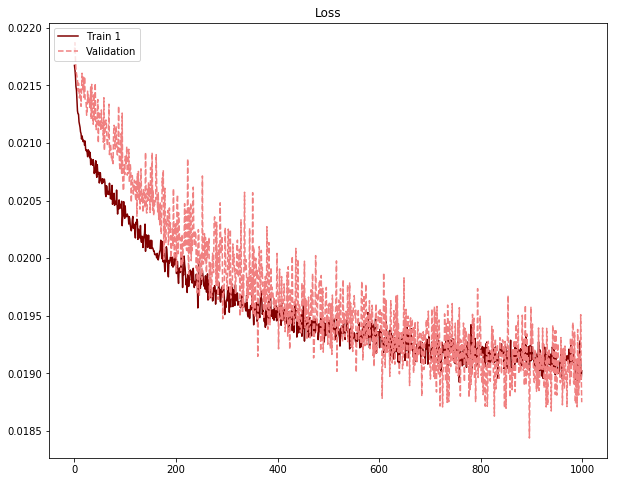

In [8]:
fig = plt.figure(figsize=(10,8))
fold = 1 
colors2 = np.array(['maroon', 'k','olive','orange', 'blue','green','blue'])
colors1 = np.array(['lightcoral','slategrey','darkseagreen', 'darkgoldenrod', 'slateblue' ])
labels_kfold = np.array(['Fold 1','Fold 2', 'Fold 3','Fold 4','Fold 5','Fold 6'])
labels_kfold = np.array(['Train 1', 'Train 2',  'Train 3', 'Train 4' ,'Train 5'])
labels_kfold2 = np.array(['Validation','Validation','Validation', 'Validation','Validation'])

for i in range(fold):
    plt.plot(final_loss_train[i,:], color=colors2[i], label=labels_kfold[i])
    plt.grid()
    plt.plot(final_loss_valid[i,:], color=colors1[i], linestyle= 'dashed', label=labels_kfold2[i])
    
    plt.grid()
    plt.title('Loss') 
    plt.legend(loc= 'upper left')  

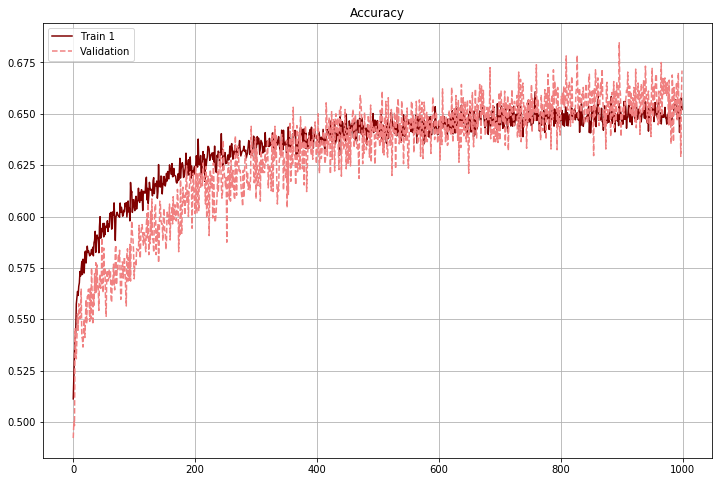

In [9]:
fig = plt.figure(figsize=(12,8))
fold = 1
colors2 = np.array(['maroon', 'k','olive','orange', 'blue','green','blue'])
colors1 = np.array(['lightcoral','slategrey','darkseagreen', 'darkgoldenrod', 'slateblue' ])
labels_kfold = np.array(['Fold 1','Fold 2', 'Fold 3','Fold 4','Fold 5','Fold 6'])
labels_kfold = np.array(['Train 1', 'Train 2',  'Train 3', 'Train 4' ,'Train 5'])
labels_kfold2 = np.array(['Validation','Validation','Validation', 'Validation','Validation'])

for i in range(fold):
    plt.plot(final_acc_train[i,:], color=colors2[i], label=labels_kfold[i])
    plt.plot(final_acc_valid[i,:], color=colors1[i], linestyle= 'dashed', label=labels_kfold2[i]) 
    plt.grid()
    plt.title('Accuracy') 
    plt.legend(loc= 'upper left')  

In [10]:
dir_bas =   '/home/mariana/Documents/Data_2D/NCAD/'+'images_total_t.npy'
dir_bas2 =  '/home/mariana/Documents/Data_2D/NCAD/'+'labels_t.npy'
dir_bas3 =  '/home/mariana/Documents/Data_2D/NCAD/'+'labels_suj_t.npy'
dir_bas4 =  '/home/mariana/Documents/Data_2D/NCAD/'+'ind_suj_t.npy'
dir_bas5 =  '/home/mariana/Documents/Data_2D/NCAD/'+'n_labels_t.npy'
dir_bas6 =  '/home/mariana/Documents/Data_2D/NCAD/'+'num_suj_t.npy' 

images_total = np.load(dir_bas)
labels       = np.load(dir_bas2)
labels_suj   = np.load(dir_bas3)
ind_suj      = np.load(dir_bas4)
n_labels     = np.load(dir_bas5)
num_suj      = np.load(dir_bas6)

print(images_total.shape)
print(labels.shape)
print(len(labels_suj))
print(len(ind_suj))
print(n_labels.shape)
print(num_suj)

(720, 3, 100, 100)
(720, 1)
18
19
(2,)
18


In [11]:
inp_set = torch.Tensor(images_total)
if cuda_aval:
    inp_set = inp_set.cuda()
feat_set = inp_set

print(feat_set.size())

torch.Size([720, 3, 100, 100])


(720,)
[[0.675 0.2   0.65  0.175 0.675 1.    0.95  0.7   0.575 0.75  0.825 0.15
  0.9   0.975 0.6   0.525 0.3   0.775]
 [0.325 0.8   0.35  0.825 0.325 0.    0.05  0.3   0.425 0.25  0.175 0.85
  0.1   0.025 0.4   0.475 0.7   0.225]]
0.5555555555555556
[1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1]
[0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
Confusion matrix, without normalization
[[7 1]
 [7 3]]
Normalized confusion matrix
[[0.88 0.12]
 [0.7  0.3 ]]


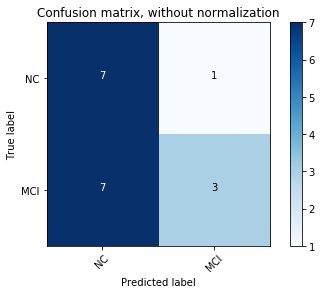

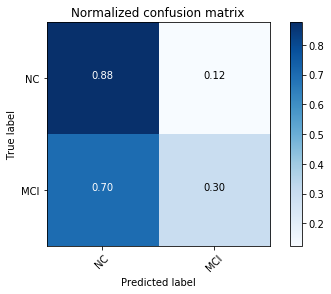

In [14]:
inp_test = torch.Tensor(images_total)
if cuda_aval:
    inp_test = inp_test.cuda()
f = 1

for f in range(f):
    fp_model = './Resn_NCMCI_Cor{}'.format(f)

    cb_chkpt = ptt.ModelCheckpoint(fp_model, reset=True, verbose=1) 
    criterion = torch.nn.CrossEntropyLoss()

    model_test = ptt.DeepNetTrainer(model = model, criterion = criterion, optimizer = optimizer,
                                            data_transf = data_transf,
                                            #lr_scheduler  = schd,
                                            callbacks = [ptt.AccuracyMetric(), cb_chkpt, ptt.PrintCallback()])

    model_test.load_state(fp_model)
    y_better_out = model_test.predict(inp_test, labels)
 
    __, y_better_out = torch.max(y_better_out, 1)
    y_better_out = y_better_out.cpu().numpy()
    print(y_better_out.shape)

    y_prob_pred, y_better_pred = get_labels(y_better_out,ind_suj[1:],ind_suj[:-1],n_labels)
    print(y_prob_pred)
    acc_k = accuracy_score(labels_suj, y_better_pred)
    print(acc_k)
    print(labels_suj.astype(int))
    print(y_better_pred)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(labels_suj, y_better_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [15]:
print(y_prob_pred)

[[0.68 0.2  0.65 0.17 0.68 1.   0.95 0.7  0.57 0.75 0.82 0.15 0.9  0.97
  0.6  0.53 0.3  0.78]
 [0.33 0.8  0.35 0.82 0.33 0.   0.05 0.3  0.42 0.25 0.17 0.85 0.1  0.03
  0.4  0.47 0.7  0.23]]


In [16]:
print(y_prob_pred, y_prob_pred.shape)
dir_bas =  '/home/mariana/Documents/Data_2D/Ens_Coronal/'+'NCMCI_only.npy'
np.save(dir_bas, y_prob_pred)

[[0.68 0.2  0.65 0.17 0.68 1.   0.95 0.7  0.57 0.75 0.82 0.15 0.9  0.97
  0.6  0.53 0.3  0.78]
 [0.33 0.8  0.35 0.82 0.33 0.   0.05 0.3  0.42 0.25 0.17 0.85 0.1  0.03
  0.4  0.47 0.7  0.23]] (2, 18)


In [5]:
dir_bas =   '/home/mariana/Documents/Data_2D/Test_1_Cor/'+'images_total.npy'
dir_bas2 =  '/home/mariana/Documents/Data_2D/Test_1_Cor/'+'labels.npy'
dir_bas3 =  '/home/mariana/Documents/Data_2D/Test_1_Cor/'+'labels_suj.npy'
dir_bas4 =  '/home/mariana/Documents/Data_2D/Test_1_Cor/'+'ind_suj.npy'
dir_bas5 =  '/home/mariana/Documents/Data_2D/Test_1_Cor/'+'n_labels.npy'
dir_bas6 =  '/home/mariana/Documents/Data_2D/Test_1_Cor/'+'num_suj.npy' 

images_total = np.load(dir_bas)
labels       = np.load(dir_bas2)
labels_suj   = np.load(dir_bas3)
ind_suj      = np.load(dir_bas4)
n_labels     = np.load(dir_bas5)
num_suj      = np.load(dir_bas6)

print(images_total.shape)
print(labels.shape)
print(len(labels_suj))
print(len(ind_suj))
print(n_labels.shape)
print(num_suj)

(1040, 3, 100, 100)
(1040, 1)
26
27
(3,)
26


In [13]:
dir_bas =   '/home/mariana/Documents/Data_2D/Test_2_Cor/'+'images_total.npy'
dir_bas2 =  '/home/mariana/Documents/Data_2D/Test_2_Cor/'+'labels.npy'
dir_bas3 =  '/home/mariana/Documents/Data_2D/Test_2_Cor/'+'labels_suj.npy'
dir_bas4 =  '/home/mariana/Documents/Data_2D/Test_2_Cor/'+'ind_suj.npy'
dir_bas5 =  '/home/mariana/Documents/Data_2D/Test_2_Cor/'+'n_labels.npy'
dir_bas6 =  '/home/mariana/Documents/Data_2D/Test_2_Cor/'+'num_suj.npy'

images_total = np.load(dir_bas)
labels       = np.load(dir_bas2)
labels_suj   = np.load(dir_bas3)
ind_suj      = np.load(dir_bas4)
n_labels     = np.load(dir_bas5)
num_suj      = np.load(dir_bas6)

print(images_total.shape)
print(labels.shape)
print(len(labels_suj))
print(len(ind_suj))
print(n_labels.shape)
print(num_suj)

(1040, 3, 100, 100)
(1040, 1)
26
27
(3,)
26


In [5]:
dir_bas  =  '/home/mariana/Documents/Data_2D/Ensamble_CERTO/'+'images_total.npy'
dir_bas2 =  '/home/mariana/Documents/Data_2D/Ensamble_CERTO/'+'labels.npy'
dir_bas3 =  '/home/mariana/Documents/Data_2D/Ensamble_CERTO/'+'labels_suj.npy'
dir_bas4 =  '/home/mariana/Documents/Data_2D/Ensamble_CERTO/'+'ind_suj.npy'
dir_bas5 =  '/home/mariana/Documents/Data_2D/Ensamble_CERTO/'+'n_labels.npy'
dir_bas6 =  '/home/mariana/Documents/Data_2D/Ensamble_CERTO/'+'num_suj.npy'

images_total = np.load(dir_bas)
labels       = np.load(dir_bas2)
labels_suj   = np.load(dir_bas3)
ind_suj      = np.load(dir_bas4)
n_labels     = np.load(dir_bas5)
num_suj      = np.load(dir_bas6)


print(images_total.shape)
print(labels.shape)
print(len(labels_suj))
print(len(ind_suj))
print(n_labels.shape)
print(num_suj)

(2080, 3, 100, 100)
(2080, 1)
52
53
(3,)
52


In [6]:
inp_set = torch.Tensor(images_total)
if cuda_aval:
    inp_set = inp_set.cuda()
feat_set = inp_set

print(feat_set.size())

torch.Size([2080, 3, 100, 100])


In [7]:
inp_test = torch.Tensor(images_total)
if cuda_aval:
    inp_test = inp_test.cuda()
f = 1

for f in range(f):
    fp_model = './Resn_NCMCI_Cor{}'.format(f)

    optimizer = optim.Adam(model.mrnd.parameters(), lr=0.00005)#, momentum=0.8)
    cb_chkpt = ptt.ModelCheckpoint(fp_model, reset=True, verbose=1) 
    criterion = torch.nn.CrossEntropyLoss()

    model_test = ptt.DeepNetTrainer(model = model, criterion = criterion, optimizer = optimizer,
                                            data_transf = data_transf,
                                            #lr_scheduler  = schd,
                                            callbacks = [ptt.AccuracyMetric(), cb_chkpt, ptt.PrintCallback()])

    model_test.load_state(fp_model)
    y_better_out = model_test.predict(inp_test, labels)
    print(y_better_out)
    y_better_out = y_better_out.cpu().numpy()
    print(y_better_out.shape)

    y_prob_pred, y_better_pred = get_labels(y_better_out,ind_suj[1:],ind_suj[:-1],n_labels)
    acc_k = accuracy_score(labels, y_better_pred)
    print(acc_k)
    print(y_better_pred.shape)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(labels, y_better_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

here tensor([[0.0000, 0.1143],
        [0.3143, 0.1429],
        [0.2286, 0.8857],
        [0.8000, 0.0857],
        [0.6857, 0.8286],
        [0.0286, 0.7143],
        [0.1429, 0.2571],
        [0.8286, 0.6857],
        [0.4286, 0.8000],
        [0.0286, 0.6286],
        [0.5714, 0.7429],
        [0.0857, 0.5429],
        [1.0000, 0.5143],
        [0.3714, 0.9714],
        [0.6571, 0.7714],
        [0.4857, 0.3143],
        [0.4857, 0.3714],
        [0.1143, 0.6000],
        [0.3429, 0.8286],
        [0.0286, 0.4000],
        [0.7429, 0.6000],
        [1.0000, 0.9143],
        [0.0000, 0.8286],
        [0.3143, 0.6571],
        [0.4000, 0.8857],
        [0.4000, 0.2000],
        [0.2857, 1.0000],
        [0.0857, 0.0000],
        [0.8571, 0.3143],
        [0.8000, 0.6286],
        [0.3429, 0.5143],
        [0.6286, 0.2286],
        [0.9143, 0.5714],
        [0.3429, 1.0000],
        [0.9429, 0.0000],
        [0.6286, 0.0857],
        [0.8857, 0.0000],
        [0.0571, 0.1143],
       

ValueError: Found input variables with inconsistent numbers of samples: [2080, 52]

In [10]:
print(NCMCI_cor.shape)

(2080, 2)


In [11]:
print(y_better_out.shape)
dir_bas =  '/home/mariana/Documents/Data_2D/Test_2_Cor/'+'NCMCI_cor.npy'
np.save(dir_bas, NCMCI_cor)

(2080, 2)
